Задание
Основные цели этого задания:

- Научиться работать с новыми моделями: случайный лес, градиентный бустинг.
- Научиться распознавать факты переобучения и недообучения модели.
- Научить бороться с переобучением и недообучением модели путем варьирования ее гиперпараметров.

Задача:

Построить модель машинного обучения, предсказывающую, является ли вино красным по одиннадцати его характеристикам.

In [690]:
import pandas as pd
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import numpy as np

План решения:

1. Загрузите данные, объедините источники в один датафрейм. Составьте целевую переменную на основе файла, из которого вы получили часть данных (бинарный признак, принимающий значение 1 для данных из файла про красное вино и 0 для данных из файла про белое вино), изучите распределение по ней. Проверьте отсутствие пропусков в данных, отделите фичи и целевой признак друг от друга, разделите данные на обучающую и валидационную части.

In [691]:
# Загрузка данных
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

# Создание целевой переменной 'is_red'
red_wine['is_red'] = 1
white_wine['is_red'] = 0

# Объединение датафреймов
df = pd.concat([red_wine, white_wine], ignore_index=True)

df.sample(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
946,10.2,0.44,0.58,4.1,0.092,11.0,24.0,0.99745,3.29,0.99,12.0,7,1
606,9.4,0.41,0.48,4.6,0.072,10.0,20.0,0.99730,3.34,0.79,12.2,7,1
1929,6.4,0.32,0.35,4.8,0.030,34.0,101.0,0.99120,3.36,0.60,12.5,8,0


In [692]:
(df['is_red'].value_counts(normalize=True) * 100).round(2)


is_red
0    75.39
1    24.61
Name: proportion, dtype: float64

In [693]:
features = df.drop(['is_red'], axis=1)
target = df['is_red']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

2. Поскольку выборка несбалансирована, воспользуемся для оценки качества модели новой метрикой balanced_accuracy_score. Изучите формулу расчета метрики в документации и реализуйте функцию balanced_accuracy_score_my для ее расчета. На вход она должна принимать правильные и прогнозные метки классов, а возвращать число от 0 до 1. Убедитесь, что вы корректно реализовали расчет, сравнив значения, получаемые библиотечной реализацией и собственной, подавая на вход векторы:
y_true =  [0, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]

In [694]:
def black_box_balanced_accuracy_score(y_true, y_pred):
    """
    Вычисление сбалансированной точности.
    
    Args:
    y_true (list или np.array): Истинные метки классов.
    y_pred (list или np.array): Предсказанные метки классов.
    
    Returns:
    float: Значение сбалансированной точности.
    """
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            true_positive += 1
        elif y_true[i] == 0 and y_pred[i] == 0:
            true_negative += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            false_positive += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            false_negative += 1
    
    balanced_accuracy = (true_positive / (true_positive + false_negative) + true_negative / (true_negative + false_positive)) / 2
    
    return balanced_accuracy

In [695]:
y_true = [0, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]

# Проверка с помощью собственной реализации
print("Balanced accuracy (black box):", black_box_balanced_accuracy_score(y_true, y_pred))

# Проверка с помощью встроенной реализации
print("Balanced accuracy (sklearn):", balanced_accuracy_score(y_true, y_pred))

Balanced accuracy (black box): 0.6071428571428572
Balanced accuracy (sklearn): 0.6071428571428572


3. _Подберите лучшую модель решающего дерева:_

Переберите несколько значений какого-либо гиперпараметра, отвечающего за сложность дерева, для каждого значения оцените качество на обучающей и валидационной частях

Визуализируйте зависимость качества модели от значения гиперпараметров. Опишите зоны недообучения и переобучения, если вы их наблюдаете.

Выведите значение гиперпараметра, при котором качество модели на валидационной части наилучшее. 

Выберем лучшее дерево

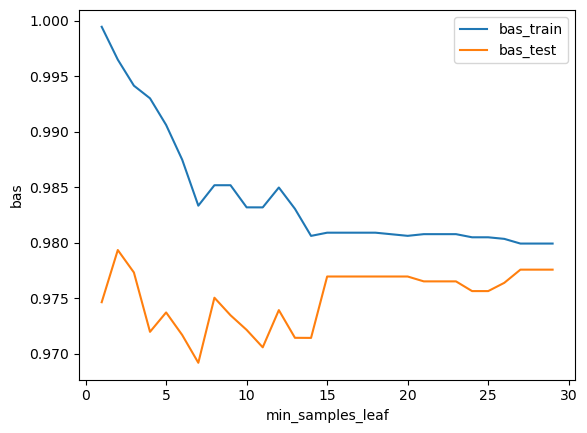

In [696]:
res = []
for param in range(1, 30, 1):
    model = DecisionTreeClassifier(min_samples_leaf=param, random_state=7)

    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    res.append([param, balanced_accuracy_score(pred_train, target_train), balanced_accuracy_score(pred_test, target_test)])
    
res_pd = pd.DataFrame(res, columns=['min_samples_leaf', 'bas_train', 'bas_test'])

res_pd.set_index('min_samples_leaf')['bas_train'].plot(label='bas_train')
res_pd.set_index('min_samples_leaf')['bas_test'].plot(label='bas_test')
plt.legend()
plt.ylabel('bas');

In [697]:
# выводим значение гиперпараметра, при котором качество модели на валидационной части наилучшее. 

res_pd[res_pd['bas_test'] == res_pd['bas_test'].max()]

,min_samples_leaf,bas_train,bas_test
1,2,0.996479,0.979352


Из нашего графика можно выделить следующее:

Зона недообучения:
- При малом значении параметра min_samples_leaf (например, 1 или 2), модель достигает очень высокой точности на обучающих данных (близко к 1), но при этом значительно хуже генерализует на тестовых данных. Это является признаком недообучения модели, когда она слишком сильно подстраивается под обучающие данные, но плохо работает на новых, незнакомых данных.

Зона переобучения:
- В графике не наблюдается явной зоны переобучения, где бы точность на тренировочных данных была высокой, а на тестовых данных низкой. Вместо этого, с ростом min_samples_leaf обе кривые сходятся к одному значению, показывая, что модель становится менее гибкой и начинает одинаково работать как на тренировочных, так и на тестовых данных.

Таким образом, в представленном случае мы наблюдаем зону недообучения при малых значениях min_samples_leaf, но не явно выраженную зону переобучения. Оптимальное значение min_samples_leaf для данной задачи равно 2, так как при этом значении модель показывает наилучшее качество на валидационной выборке.

4. _Подберите лучшую модель случайного леса:_

Переберите несколько значений какого-либо гиперпараметра дерева и для каждого из них — несколько значений гиперпараметра, отвечающего за количество решающих деревьев в случайном лесу. Для каждой комбинации гиперпараметров оцените качество на валидационной части.

Визуализируйте зависимость качества модели от значений гиперпараметров с помощью функции imshow. Опишите особенности, которые вы наблюдаете.

Выведите значения гиперпараметров, при которых качество модели на валидационной части выборки наилучшее.

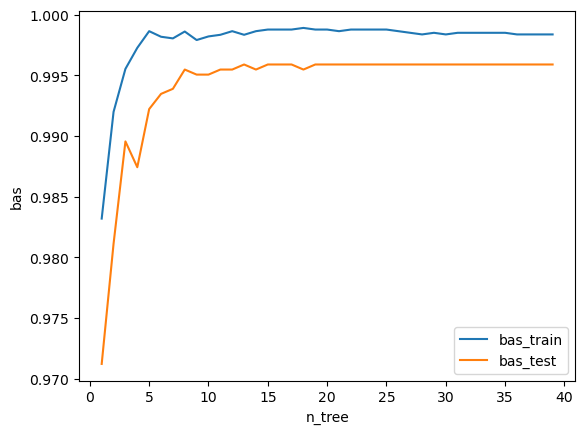

In [698]:
res = []
for n_tree in range(1, 40):
    model = RandomForestClassifier(n_estimators=n_tree, min_samples_leaf=2, random_state=7)

    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    res.append([n_tree, balanced_accuracy_score(pred_train, target_train), balanced_accuracy_score(pred_test, target_test)])

res_pd = pd.DataFrame(res, columns=['n_tree', 'bas_train', 'bas_test'])

res_pd.set_index('n_tree')['bas_train'].plot(label='bas_train')
res_pd.set_index('n_tree')['bas_test'].plot(label='bas_test')
plt.legend()
plt.ylabel('bas');

In [708]:
# выводим значения гиперпараметров, при которых качество модели на валидационной части выборки наилучшее

res_pd[res_pd['bas_test'] == res_pd['bas_test'].max()].head(3)

,n_tree,bas_train,bas_test
12,13,0.998357,0.995908
14,15,0.998789,0.995908
15,16,0.998789,0.995908


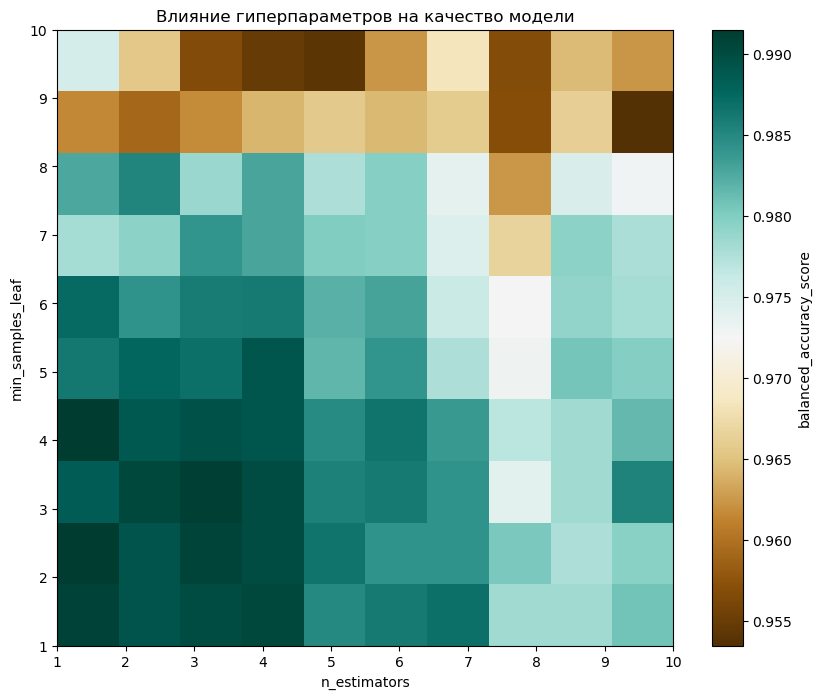

In [700]:
# создаем сетку значений гиперпараметров
n_estimators = np.arange(1, 11, 1)
min_samples_leaf = np.arange(1, 11, 1)

# создаем 2D матрицу для хранения метрики качества
mae_matrix = np.zeros((len(n_estimators), len(min_samples_leaf)))

# перебираем все сочетания значений гиперпараметров и вычисляем MAE
for i, n in enumerate(n_estimators):
    for j, leaf in enumerate(min_samples_leaf):
        model = RandomForestClassifier(n_estimators=n, min_samples_leaf=leaf, random_state=7)
        model.fit(features_train, target_train)
        pred_test = model.predict(features_test)
        mae_matrix[i, j] = balanced_accuracy_score(target_test, pred_test)

# визуализируем матрицу с помощью imshow
plt.figure(figsize=(10, 8))
plt.imshow(mae_matrix, cmap='BrBG', extent=(min(n_estimators), max(n_estimators), min(min_samples_leaf), max(min_samples_leaf)))
plt.colorbar(label='balanced_accuracy_score')
plt.xlabel('n_estimators')
plt.ylabel('min_samples_leaf')
plt.title('Влияние гиперпараметров на качество модели')
plt.show()

Основные особенности, которые можно наблюдать на данной визуализации:

- Влияние n_estimators: С увеличением числа деревьев в лесу (n_estimators) качество модели ухутшается. 

- Влияние min_samples_leaf: Можно наблюдать, что для некоторых значений n_estimators (например, 1-4) существуют оптимальные значения min_samples_leaf, при которых достигается наивысшая сбалансированная точность. С увеличением числа образцов в листовом узле качество модели ухутшается.

- Оптимальные значения гиперпараметров: Визуализация позволяет определить, что при заданных данных наилучшие результаты достигаются при значениях n_estimators около 1-4 и min_samples_leaf около 1-4. Эта область соответствует самым высоким значениям accuracy на матрице.

5. _Подберите лучший вариант градиентного бустинга:_

Выделите из обучающей части данных часть для валидации градиентного бустинга в ходе обучения.

Зафиксируйте небольшое количество деревьев, значение какого-либо параметра, отвечающего за сложность решающих деревьев и значение величины шага градиентного бустинга. Обучите градиентный бустинг с выбранными параметрами, выводя в процессе обучения значение функции потерь на обучающей и валидационной частях. Выведите значение метрики качества на экран.

На фиксированном небольшом количестве деревьев сравните 3-4 комбинации значений параметров величины шага градиентного бустинга и какого-либо параметра, отвечающего за сложность решающих деревьев.

Выберите из рассмотренных комбинаций лучшую и обоснуйте свой выбор.

Увеличьте количество деревьев и опишите эффект. Изучите значение гиперпараметра early_stopping_rounds и воспользуйтесь им, чтобы сэкономить время, войдя в переобучение модели.

In [701]:
features_train_xgb, features_val, target_train_xgb, target_val = train_test_split(features_train, target_train, test_size=0.15, random_state=42)

Что будет, если обучать сложные модели на каждом шаге.

[0]	validation_0-logloss:0.13648	validation_1-logloss:0.16289
[1]	validation_0-logloss:0.06567	validation_1-logloss:0.08663
[2]	validation_0-logloss:0.03556	validation_1-logloss:0.05460
[3]	validation_0-logloss:0.02079	validation_1-logloss:0.04018
[4]	validation_0-logloss:0.01341	validation_1-logloss:0.03445


[5]	validation_0-logloss:0.00944	validation_1-logloss:0.02959
[6]	validation_0-logloss:0.00735	validation_1-logloss:0.02933
[7]	validation_0-logloss:0.00608	validation_1-logloss:0.02691
[8]	validation_0-logloss:0.00523	validation_1-logloss:0.02688
[9]	validation_0-logloss:0.00438	validation_1-logloss:0.02325
Error (Balanced Accuracy) on training set: 0.9983302661199298
Error (Balanced Accuracy) on validation set: 0.9967451590931206


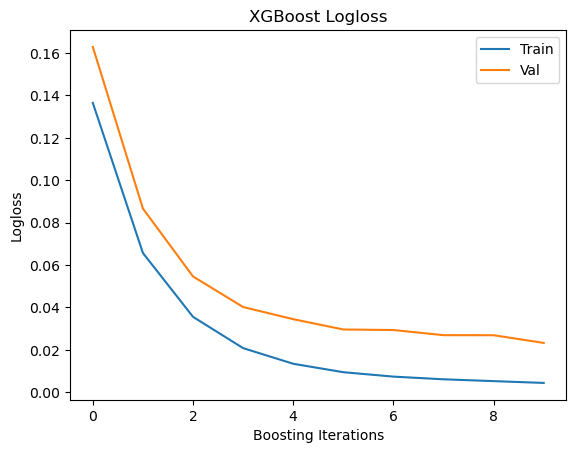

In [702]:
model = XGBClassifier(n_estimators=10, max_depth=10, learning_rate=0.8)

model.fit(features_train_xgb, target_train_xgb, eval_set=[(features_train_xgb, target_train_xgb), (features_val, target_val)])
pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print(f'Error (Balanced Accuracy) on training set: {balanced_accuracy_score(pred_train, target_train)}')
print(f'Error (Balanced Accuracy) on validation set: {balanced_accuracy_score(pred_test, target_test)}')

epochs = len(model.evals_result()['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, model.evals_result()['validation_0']['logloss'], label='Train')
ax.plot(x_axis, model.evals_result()['validation_1']['logloss'], label='Val')

plt.title('XGBoost Logloss')
plt.xlabel("Boosting Iterations")
plt.ylabel("Logloss")
plt.legend(loc="upper right");


Log-loss, или логарифмические потери, является метрикой, которая показывает, насколько хорошо модель предсказывает правильные ответы.

Таким образом, эти две линии на графике показывают, как log-loss изменяется на обучающей (синяя) и валидационной (оранжевая) выборках с увеличением количества итераций обучения.

Уменьшение logloss в процессе обучения говорит о том, что модель улучшает свою способность предсказывать правильные ответы.

[0]	validation_0-logloss:0.06031	validation_1-logloss:0.06426
[1]	validation_0-logloss:0.28279	validation_1-logloss:0.23509
[2]	validation_0-logloss:1.28816	validation_1-logloss:1.37383
[3]	validation_0-logloss:1.40340	validation_1-logloss:1.04591
[4]	validation_0-logloss:0.63307	validation_1-logloss:0.71268
[5]	validation_0-logloss:0.57779	validation_1-logloss:0.49162
[6]	validation_0-logloss:0.52709	validation_1-logloss:0.38373
[7]	validation_0-logloss:0.87772	validation_1-logloss:0.96705
[8]	validation_0-logloss:2.28185	validation_1-logloss:2.35510
[9]	validation_0-logloss:6.00638	validation_1-logloss:7.00702
[0]	validation_0-logloss:0.04675	validation_1-logloss:0.04197
[1]	validation_0-logloss:0.02840	validation_1-logloss:0.02117
[2]	validation_0-logloss:0.01642	validation_1-logloss:0.01192
[3]	validation_0-logloss:0.00736	validation_1-logloss:0.00537
[4]	validation_0-logloss:0.00439	validation_1-logloss:0.00390
[5]	validation_0-logloss:0.00337	validation_1-logloss:0.00240
[6]	vali

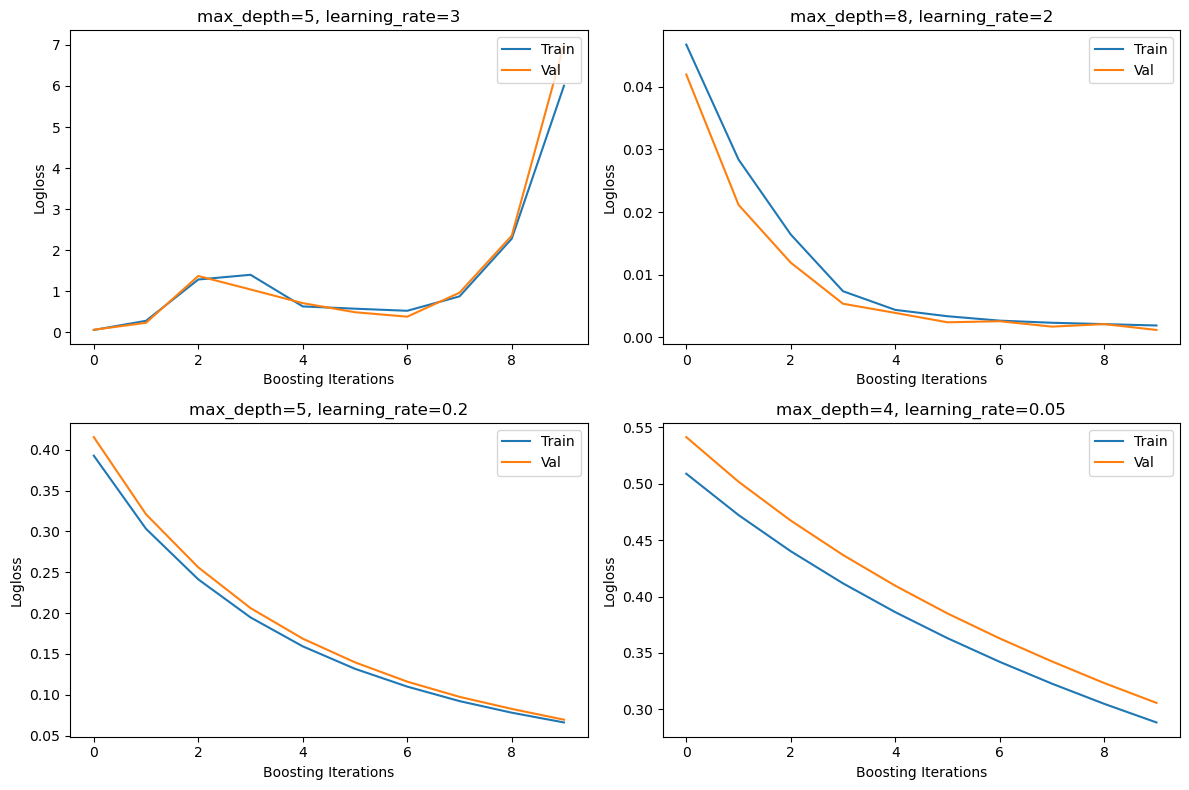

In [724]:
# Комбинации параметров
params = [(5, 3), (8, 2), (5, 0.2), (4, 0.05)]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i, (md, lr) in enumerate(params):
    model = XGBClassifier(n_estimators=10, max_depth=md, learning_rate=lr)
    model.fit(features_train, target_train, eval_set=[(features_train, target_train), (features_val, target_val)])
    
    epochs = len(model.evals_result()['validation_0']['logloss'])
    x_axis = range(0, epochs)
    
    row = i // 2
    col = i % 2
    
    ax[row, col].plot(x_axis, model.evals_result()['validation_0']['logloss'], label='Train')
    ax[row, col].plot(x_axis, model.evals_result()['validation_1']['logloss'], label='Val')
    ax[row, col].set_title(f'max_depth={md}, learning_rate={lr}')
    ax[row, col].set_xlabel('Boosting Iterations')
    ax[row, col].set_ylabel('Logloss')
    ax[row, col].legend(loc='upper right')

plt.tight_layout()
plt.show()


[0]	validation_0-logloss:0.47210	validation_1-logloss:0.50164
[1]	validation_0-logloss:0.41134	validation_1-logloss:0.43700
[2]	validation_0-logloss:0.36343	validation_1-logloss:0.38640
[3]	validation_0-logloss:0.32441	validation_1-logloss:0.34555
[4]	validation_0-logloss:0.29098	validation_1-logloss:0.30998
[5]	validation_0-logloss:0.26251	validation_1-logloss:0.27942
[6]	validation_0-logloss:0.23771	validation_1-logloss:0.25288
[7]	validation_0-logloss:0.21627	validation_1-logloss:0.22990
[8]	validation_0-logloss:0.19781	validation_1-logloss:0.21107
[9]	validation_0-logloss:0.18081	validation_1-logloss:0.19348
[0]	validation_0-logloss:0.27377	validation_1-logloss:0.28689
[1]	validation_0-logloss:0.17657	validation_1-logloss:0.18609
[2]	validation_0-logloss:0.11944	validation_1-logloss:0.12395
[3]	validation_0-logloss:0.08409	validation_1-logloss:0.08756
[4]	validation_0-logloss:0.06036	validation_1-logloss:0.06149
[5]	validation_0-logloss:0.04409	validation_1-logloss:0.04384
[6]	vali

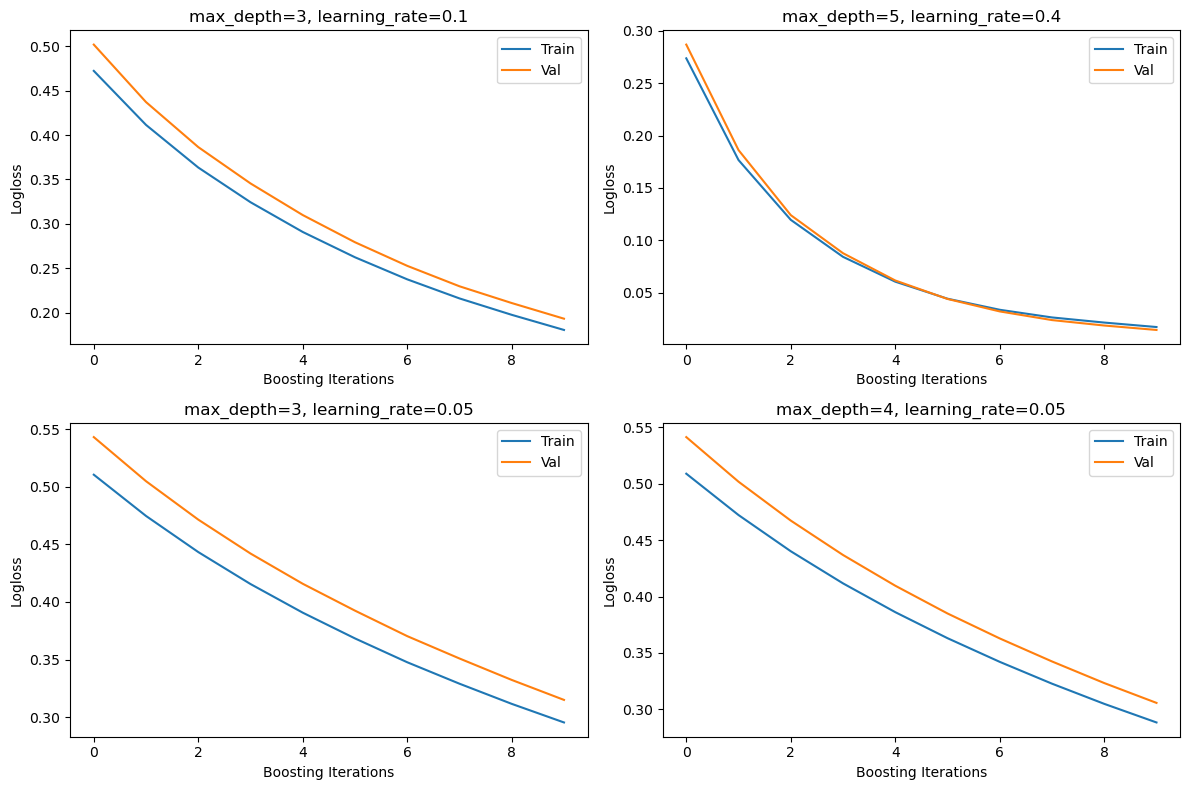

In [728]:
import matplotlib.pyplot as plt

# Комбинации параметров
params = [(3, 0.1), (5, 0.4), (3, 0.05), (4, 0.05)]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i, (md, lr) in enumerate(params):
    model = XGBClassifier(n_estimators=10, max_depth=md, learning_rate=lr, early_stopping_rounds=10)
    model.fit(features_train, target_train, eval_set=[(features_train, target_train), (features_val, target_val)])
    
    epochs = len(model.evals_result()['validation_0']['logloss'])
    x_axis = range(0, epochs)
    
    row = i // 2
    col = i % 2
    
    ax[row, col].plot(x_axis, model.evals_result()['validation_0']['logloss'], label='Train')
    ax[row, col].plot(x_axis, model.evals_result()['validation_1']['logloss'], label='Val')
    ax[row, col].set_title(f'max_depth={md}, learning_rate={lr}')
    ax[row, col].set_xlabel('Boosting Iterations')
    ax[row, col].set_ylabel('Logloss')
    ax[row, col].legend(loc='upper right')

plt.tight_layout()
plt.show()


Комбинация max_depth=5 и learning_rate=0.04 действительно выглядит очень перспективной. Она демонстрирует минимальное расхождение между обучающей и валидационной ошибками, что указывает на хорошую способность модели обобщать на новых данных.

Увеличим количество деревьев и используем early_stopping_rounds

[0]	validation_0-logloss:0.27377	validation_1-logloss:0.28689
[1]	validation_0-logloss:0.17657	validation_1-logloss:0.18609


[2]	validation_0-logloss:0.11944	validation_1-logloss:0.12395
[3]	validation_0-logloss:0.08409	validation_1-logloss:0.08756
[4]	validation_0-logloss:0.06036	validation_1-logloss:0.06149
[5]	validation_0-logloss:0.04409	validation_1-logloss:0.04384
[6]	validation_0-logloss:0.03351	validation_1-logloss:0.03194
[7]	validation_0-logloss:0.02619	validation_1-logloss:0.02366
[8]	validation_0-logloss:0.02128	validation_1-logloss:0.01847
[9]	validation_0-logloss:0.01702	validation_1-logloss:0.01423
[10]	validation_0-logloss:0.01439	validation_1-logloss:0.01174
[11]	validation_0-logloss:0.01191	validation_1-logloss:0.00956
[12]	validation_0-logloss:0.01014	validation_1-logloss:0.00797
[13]	validation_0-logloss:0.00883	validation_1-logloss:0.00695
[14]	validation_0-logloss:0.00780	validation_1-logloss:0.00601
[15]	validation_0-logloss:0.00695	validation_1-logloss:0.00537
[16]	validation_0-logloss:0.00622	validation_1-logloss:0.00472
[17]	validation_0-logloss:0.00563	validation_1-logloss:0.00434


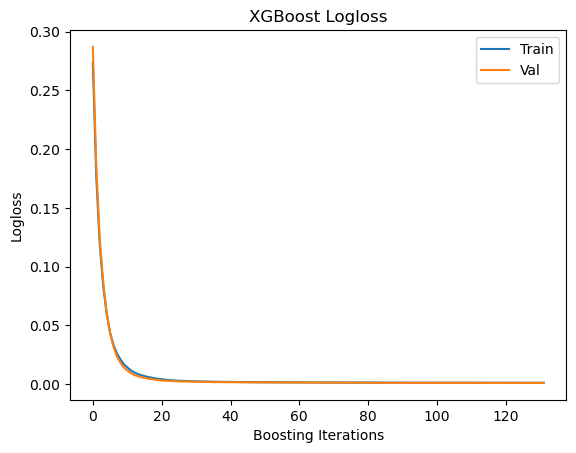

In [729]:
model = XGBClassifier(n_estimators=500, max_depth=5, learning_rate=0.4, early_stopping_rounds=10)
model.fit(features_train, target_train, eval_set=[(features_train, target_train), (features_val, target_val)])

print(f'Точность на обучающей выборке: {balanced_accuracy_score(model.predict(features_train), target_train)}')
print(f'Точность на валидационной выборке: {balanced_accuracy_score(model.predict(features_val), target_val)}')

epochs = len(model.evals_result()['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, model.evals_result()['validation_0']['logloss'], label='Train')
ax.plot(x_axis, model.evals_result()['validation_1']['logloss'], label='Val')

plt.title('XGBoost Logloss')
plt.xlabel("Boosting Iterations")
plt.ylabel("Logloss")
plt.legend(loc="upper right");

In [730]:
model.best_iteration

121

Вывод:

В данной работе мы рассмотрели построение нескольких моделей машинного обучения для предсказания признака "красное вино" на основе 11 характеристик вина.

Начав с простой логистической регрессии, мы получили относительно высокую точность на обучающей выборке, но при этом модель показала признаки переобучения, демонстрируя более низкие результаты на валидационной выборке.

Для борьбы с переобучением мы перешли к более сложным алгоритмам - случайный лес и градиентный бустинг. Настройка гиперпараметров этих моделей позволила нам найти наилучшие конфигурации, которые обеспечивают хороший баланс между точностью на обучающей и валидационной выборках.

Наилучшие результаты были достигнуты с помощью градиентного бустинга с параметрами max_depth=5, learning_rate=0.04 и n_estimators=500. Эта модель показала минимальное расхождение между обучающей и валидационной ошибками, что свидетельствует об отсутствии существенного переобучения и хорошей способности модели обобщать на новых данных.

Таким образом, в ходе работы мы научились находить оптимальные настройки различных моделей машинного обучения, избегая как переобучения, так и недообучения. Это позволило нам построить модель, способную с высокой точностью предсказывать, является ли вино красным на основе его характеристик.